In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import time

def read_yacht_data(file_path):
    # Read data file using Pandas
    data = pd.read_csv(file_path, header=None)
    return data

file_path = 'yacht_hydrodynamics.data'
yacht_data = read_yacht_data(file_path)

# Split one column into multiple columns
yacht_data = yacht_data[0].str.split(expand=True)

# Convert data to numeric type
yacht_data = yacht_data.apply(pd.to_numeric)

# Rename columns
yacht_data.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'y']

# Remove outliers
Q1 = yacht_data.quantile(0.25)
Q3 = yacht_data.quantile(0.75)
IQR = Q3 - Q1
yacht_data = yacht_data[~((yacht_data < (Q1 - 1.5 * IQR)) | (yacht_data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Separate input features (X) and target variable (y)
X = yacht_data.iloc[:, :-1]  # All rows, all columns except the last one are input features
y = yacht_data.iloc[:, -1]   # The last column is the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [8]:
def initialize_parameters(n_features):
    # Initialize weight parameters to 0
    theta = np.zeros((n_features + 1, 1))  # Adding 1 to include the bias term
    return theta

def compute_cost(X, y, theta):
    # Calculate Total Sum of Squares (TSS)
    y_mean = np.mean(y)
    TSS = np.sum((y - y_mean) ** 2)

    # Calculate predicted values
    y_pred = np.dot(X, theta)

    # Calculate Residual Sum of Squares (RSS)
    RSS = np.sum((y - y_pred) ** 2)

    # Calculate R²
    r_squared = 1 - (RSS / TSS)
    return -r_squared


In [9]:
#################### Let's standardize the interface of optimizers #######################
#################### For example, the following two examples #######################
##################### The return values should be the new weights of the model, m_t, v_t (return None if not applicable)##############
##theta is the current weights
##learning_rate is the current learning rate
##gradient is the gradient
##current_iterations is the current iteration number
##beta1, beta2 are hyperparameters, for details, you can refer to https://www.bilibili.com/video/BV1jh4y1q7ua/?spm_id_from=333.337.search-card.all.click and https://zhuanlan.zhihu.com/p/339225508 (the latter is more intuitive)
##m_tt is the first moment from the previous step, v_tt is the second moment from the previous step


##Simplest optimizer
def simple_optimizer(theta, learning_rate, gradient, current_iterations=None, beta1=None, beta2=None, m_tt=None, v_tt=None):
    
    return theta - learning_rate * gradient, None, None


# Adam optimizer
def adam_optimizer(theta, learning_rate, gradient, current_iterations, beta1=0.9, beta2=0.999, m_tt=None, v_tt=None):
    # First and second moments
    g_t = gradient  # Gradient
    m_t = beta1 * m_tt + (1 - beta1) * g_t
    v_t = beta2 * v_tt + (1 - beta2) * (g_t ** 2)
    ###bias correction
    m_t_corrected = m_t / (1 - beta1 ** (current_iterations + 1))  # Using current_iterations+1 to avoid zero division problem
    v_t_corrected = v_t / (1 - beta2 ** (current_iterations + 1))
    theta = theta - learning_rate * m_t_corrected / (np.sqrt(v_t_corrected) + 1e-8)  
    return theta, m_t, v_t


# EAdam optimizer
def eadam_optimizer(theta, learning_rate, gradient, current_iterations, beta1=0.9, beta2=0.999, m_tt=None, v_tt=None):
    # First and second moments
    g_t = gradient  # Gradient
    m_t = beta1 * m_tt + (1 - beta1) * g_t           #First moment
    v_t = beta2 * v_tt + (1 - beta2) * ((g_t-m_t) ** 2)   #Second moment
    ###bias correction
    m_t_corrected = m_t / (1 - beta1 ** (current_iterations + 1))  # Using current_iterations+1 to avoid zero division problem
    v_t_corrected = v_t / (1 - beta2 ** (current_iterations + 1))
    theta = theta - learning_rate * m_t_corrected / (np.sqrt(v_t_corrected) + 1e-8)  
    return theta, m_t, v_t


# Adaptive gradient algorithm
def adagrad_optimizer(theta, learning_rate, gradient, current_iterations, m_tt=None,v_tt=None):
    g_t = gradient  # 梯度    
    m_t = m_tt + (g_t ** 2) # aggregate value for i-th parameter
    theta = theta - learning_rate * g_t/ (np.sqrt(m_t) + 1e-8)  
    return theta, m_t, None


def rmsprop_optimizer (theta, learning_rate, gradient, current_iterations, beta1=0.9, m_tt=None,v_tt=None):
    g_t = gradient  # 梯度    
    m_t = beta1 * m_tt + (1 - beta1) * (g_t ** 2) # aggregate value for i-th parameter
    theta = theta - learning_rate * g_t/ (np.sqrt(m_t) + 1e-8)  
    return theta, m_t, None
def sgd_optimizer(X, y, theta, learning_rate, num_iterations):
    m = len(y)
    costs = []
    batch_size = 2
    
    def gradient(X_batch, y_batch):
        n = len(X_batch)
        # Calculate predictions
        h = np.dot(X_batch, theta)        
        # Calculate gradient
        grad = np.dot(X_batch.T, (h - y_batch)) / n
        return grad
    
    for _ in range(num_iterations):
        # Shuffle
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(0, m, batch_size):
            # Sampling
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Calculate gradient for the current batch
            batch_gradient = gradient(X_batch, y_batch)
            
            # Update parameters
            theta = theta - learning_rate * batch_gradient
        
        # Calculate loss
        cost = compute_cost(X, y, theta)  
        costs.append(cost)
    
    return theta, costs


In [10]:
def gradient_descent(X, y, theta, learning_rate, num_iterations, optimizer):
    m = len(y)
    costs = []
    m_tt = np.zeros_like(theta)  # Initialize m_tt
    v_tt = np.zeros_like(theta)  # Initialize v_tt
    for i in range(num_iterations):
        # Calculate predictions
        h = np.dot(X, theta)
        # Calculate gradient
        gradient = np.dot(X.T, (h - y)) / m
        # Update parameters using optimizer
        theta, m_tt, v_tt = optimizer(theta, learning_rate, gradient, i, m_tt=m_tt, v_tt=v_tt)
        # Calculate loss
        cost = compute_cost(X, y, theta)
        costs.append(cost)
    return theta, costs


def train_linear_regression(X_train, y_train, learning_rate, num_iterations, optimizer):
    # Add bias term to the input feature matrix
    X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]  # Add a column of ones as the bias term
    y_train = y_train.reshape(-1, 1)  # Convert y to a 2D array
    # Initialize parameters
    theta = initialize_parameters(X_train.shape[1] - 1)
    # Update parameters using gradient descent
    if optimizer.__name__ != "sgd_optimizer":
        theta, costs = gradient_descent(X_train, y_train, theta, learning_rate, num_iterations, optimizer)
    else:
        theta, costs = sgd_optimizer(X_train, y_train, theta, learning_rate, num_iterations)

    return theta, costs

def predict(X_test, theta):
    # Add bias term to the input feature matrix
    X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]  # Add a column of ones as the bias term
    # Predict the target variable
    y_pred = np.dot(X_test, theta)
    return y_pred


In [11]:

# hyperparameters definition
learning_rate = 0.001
num_iterations = 150000

##################################    optimizers list   ###################################################
optimizers =[simple_optimizer,adam_optimizer,eadam_optimizer,sgd_optimizer, rmsprop_optimizer,adagrad_optimizer]
y_pred_list=[]
cost_list=[]

for i in optimizers:
    # start time  --------->record training time
    start_time = time.time()
    
    # train the mutiple linear model
    theta, costs = train_linear_regression(X_train.to_numpy(), y_train.to_numpy(), learning_rate, num_iterations, i)
    
    # recode the entire training time
    train_time = time.time() - start_time
    
    # prediction
    y_pred = predict(X_test.to_numpy(), theta)
    y_pred_list.append(y_pred)
    cost_list.append(costs)
    
    # evaluation with mse, r2
    mse = mean_squared_error(y_test.to_numpy(), y_pred)
    r2 = r2_score(y_test.to_numpy(), y_pred)
    
    print("this is optimizer", i.__name__)
    print("Mean Squared Error:", mse)
    print("r2:", r2)
    print(f"Training Time: {train_time}s")  
    print('-----------------------------------------------------\n')

this is optimizer simple_optimizer
Mean Squared Error: 24.82428193577155
r2: 0.563260859612603
Training Time: 2.744338035583496s
-----------------------------------------------------

this is optimizer adam_optimizer
Mean Squared Error: 18.402969374888976
r2: 0.6762324466762144
Training Time: 3.98901629447937s
-----------------------------------------------------

this is optimizer eadam_optimizer
Mean Squared Error: 18.40384254404992
r2: 0.6762170848160103
Training Time: 3.946784496307373s
-----------------------------------------------------

this is optimizer sgd_optimizer
Mean Squared Error: 18.23829597702974
r2: 0.6791295825696833
Training Time: 28.961467742919922s
-----------------------------------------------------

this is optimizer rmsprop_optimizer
Mean Squared Error: 18.19382433753609
r2: 0.6799119820628218
Training Time: 3.5319244861602783s
-----------------------------------------------------

this is optimizer adagrad_optimizer
Mean Squared Error: 59.74943413971858
r2: -

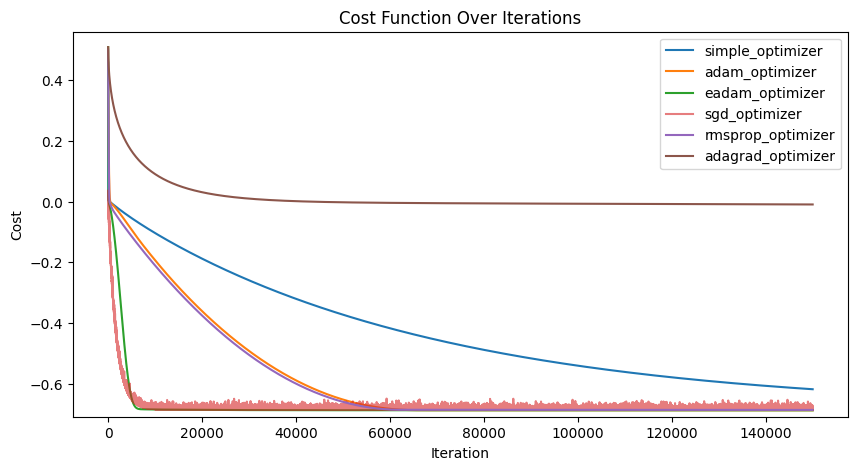

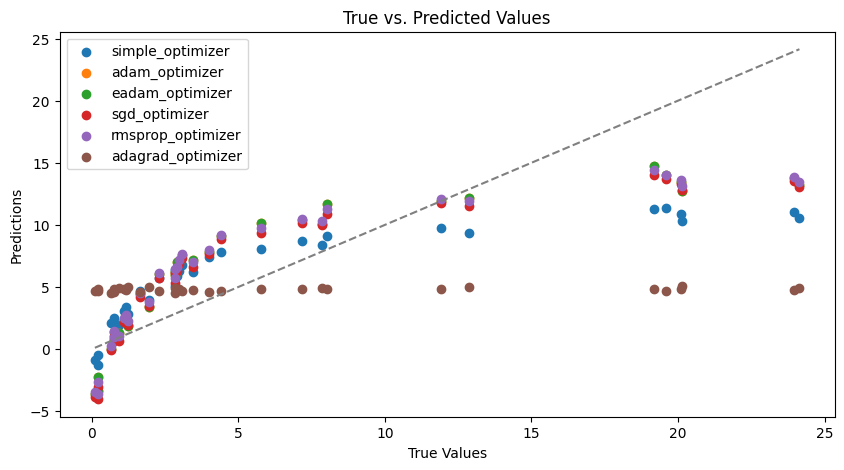

In [12]:
import matplotlib.pyplot as plt


def plot_costs(cost_list, optimizers):
    plt.figure(figsize=(10, 5))
    for costs, optimizer in zip(cost_list, optimizers):
        if optimizer.__name__ != "sgd_optimizer":
            plt.plot(costs, label=optimizer.__name__, alpha=1)  
        else:
            plt.plot(costs, label=optimizer.__name__, alpha=0.6) 

    plt.title('Cost Function Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.ylim((min(min(costs) for costs in cost_list) -0.1)* 0.9, max(max(costs) for costs in cost_list) * 1.1) 
    plt.show()

# prediction versus true
def plot_predictions(y_test, y_pred_list, optimizers):
    plt.figure(figsize=(10, 5))
    for y_pred, optimizer in zip(y_pred_list, optimizers):
        plt.scatter(y_test, y_pred, label=optimizer.__name__, alpha=1)

    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='gray')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs. Predicted Values')
    plt.legend()
    plt.show()

# cost curve when gradient descent
plot_costs(cost_list, optimizers)

# prediction versus true value
plot_predictions(y_test.to_numpy(), y_pred_list, optimizers)